# DNA structure generator

Thor van Heesch (T.vanHeesch@uva.nl) & Jocelyne Vreede (J.Vreede@uva.nl), van 't Hoff Institute for Molecular Sciences, University of Amsterdam, May 2024

This tutorial lets you generate linear DNA, curved DNA and knotted DNA. The code in this tutorial is based on `pyMDNA`, using rigid body representations for base pairs, publication in preparation. 

To go through the tutorial, run each cell with code, using either shift-enter or the play button.  

Start with importing relevant libraries. 


In [3]:
#import libraries
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import nglview as nv

import sys
sys.path.append('/Users/thor/surfdrive/Projects/pymdna/')
import pymdna as mdna 

### Linear DNA

The `sequence_to_pdb()` function can generate a 3D DNA structure and takes the nucleotide sequence as input:

In [4]:
sequence='CGCGAATTCGCG'
traj = mdna.sequence_to_pdb(sequence)

Sequence: CGCGAATTCGCG
Number of base pairs: 12


Visualize the DNA structure. Try out ribbon and atom (=licorice or spacefill) representation by uncommenting and commenting out code in the cell below. Each time the code is changed, run the cell again to update the visualization. 

Documentation on NGLview: https://nglviewer.org/ngl/api/manual/molecular-representations.html

The following section shows what happens under the hood:

In [5]:
# Linear strand of control points 
point = mdna.Shapes.line((len(sequence)-1)*0.34)

To change the twist of the DNA we can modified the following arguments:

`bp_per_turn` (float, optional): Number of base pairs per turn. Default is 10.5. 

`modified_ranges` (list, optional): List of tuples containing the start and end indices  of the modified ranges and the twist angle `[[index_a, index_b, mod_twist]]`.

The default twist per base is `360/bp_per_turn` = `34.3`, however we can increase this value to overtwist or decrease to undertwist the DNA.

In [32]:
# Convert the control points to a spline and change the twist of the DNA: for the first to third undertwisted, and sixth to ninth overtwisted
spline = mdna.SplineFrames(point, twist=True, modified_ranges=[[0,3,12],[6,9,50]])

# Generate the DNA structure
generator = mdna.StructureGenerator(sequence=sequence,spline=spline)

# Edit the DNA structure to make it compatible with the AMBER force field
traj = generator.traj

In [33]:
view = nv.show_mdtraj(traj)
view.clear()
#view.add_cartoon()
view.add_licorice()
#view.add_spacefill()
view

NGLWidget()

In [30]:
# Convert the control points to a spline and change the twist of the DNA: for the first to third undertwisted, and sixth to ninth overtwisted
spline = mdna.SplineFrames(point, twist=True, bp_per_turn=-20)

# Generate the DNA structure
generator = mdna.StructureGenerator(sequence=sequence,spline=spline)

# Edit the DNA structure to make it compatible with the AMBER force field
traj = generator.traj

In [31]:
view = nv.show_mdtraj(traj)
view.clear()
#view.add_cartoon()
view.add_licorice()
#view.add_spacefill()
view

NGLWidget()

Make DNA of length 12, 21 and 42 basepairs. Notice the number of complete turns. 

### Curved DNA

To construct curved DNA, we use a parametric function in three dimensions, defined by three functions, one for each dimension (x, y, z), depending on one or more parameters. Let's define a spiral parametric function depending on a single parameter `t`:

In [35]:
def parametric_spiral(t, radius=5):
    x = np.cos(t)*radius
    y = np.sin(t)*radius
    z = t  # Linear increment for simplicity
    return x, y, z

Now, generate a range of values for `t`, from 0 to 3π with 100 points. For each value of `t`, `x`, `y`, and `z` coordinates are computed using the parametric function: 

In [36]:
t = np.linspace(0, 3 * np.pi, 100)
x, y, z = parametric_spiral(t)

Plot the three dimensional spiral curve:

Text(0.5, 0.92, '3D Parametric Curve')

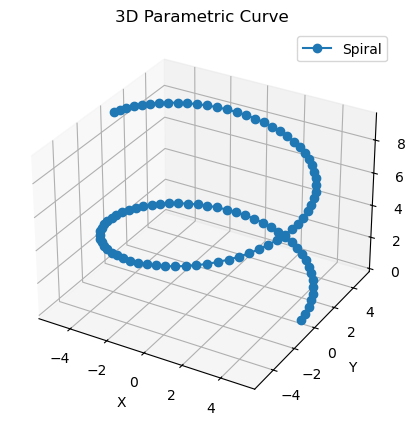

In [56]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(x, y, z, 'o-', label='Spiral')
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_title('3D Parametric Curve')


Now we can use the the x,y,z coordinates to define control points to construct a spline. A spline is a mathematical function used to create smooth curves. It is a type of piecewise polynomial function that is very versatile due to its parametric nature.

In [7]:
control_points = np.array([x, y, z]).T  # Create a (n_points, 3) array
spline = mdna.SplineFrames(control_points)

Now visualize the spline in three dimensions. Notice that each point has an orthonormal basis, the rigid body reference frame for each basepair. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


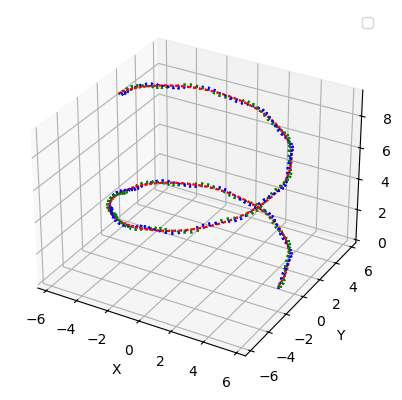

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>)

In [8]:
spline.plot_frames(equal=True)

 These reference frames provide a position and mapping to construct the positions of atoms in DNA base pairs. In the following code, atomic positions are generated using the reference frames. The sequence is randomized, unless a sequence is provided. Note that for a predefined sequence, the number of base pairs must match the number of reference frames. 

In [9]:
sequence = None # Make sure if you create your own sequence, it has the same length as the number of base pairs n_bp 
generator = mdna.StructureGenerator(spline)

n_bp = spline.frames.shape[0]
print(f'Number of base pairs is {n_bp} that fit along the spline.')
traj = generator.traj
traj

TGCCAGGGCATGTACGGACACAAACAGGCTTTTTATCGGCCCAGCCGGCTATGTGAAATTCGCGTACTATAGCTACAGCACGATGGAAAATCGACTGTAACTGAGCGCAAGTCTGACCCTGTGCAAAGGGGTTGGATCCGCC
Number of base pairs is 142 that fit along the spline.


<mdtraj.Trajectory with 1 frames, 5822 atoms, 284 residues, without unitcells at 0x18383e1d0>

Next, we can view the structure:

In [10]:
view = nv.show_mdtraj(traj)
#view.add_licorice()
#view.add_spacefill()
view

NGLWidget()

## Knotted DNA

Generate a DNA structure shaped in the form of a knot! 

To do so you need to define the knot as a paramatric function. Below the parametric functions of the trefoil knot and the figure-eight knot are provided. You can add a new function with the parametric function of another knot. See https://mathcurve.com/courbes3d.gb/noeuds/noeud.shtml for an overview of knots and several parametric representations. 

Note that to generate a DNA structure from the spline, there needs to be sufficient room for the basepairs. You can tune this with the `radius` parameter in the parametric functions. The more basepairs you include, the longer it takes to generate a structural model. 

In [11]:
def parametric_trefoil(t, radius=1):
    x = radius*(np.sin(t)) + radius*(2*np.sin(2*t)) 
    y = radius*(np.cos(t)) - radius*(2*np.cos(2*t))
    z = radius*(-np.sin(3*t))
    return x, y, z

In [12]:
def parametric_figure_eight(t, scaling=1/32):
    x = scaling*32*np.cos(t) - scaling*51*np.sin(t) - scaling*104*np.cos(2*t) - scaling*34*np.sin(2*t) + scaling*104*np.cos(3*t) - scaling*91*np.sin(3*t)
    y = scaling*94*np.cos(t)+ scaling*41*np.sin(t) + scaling*113*np.cos(2*t) - scaling*68*np.cos(3*t) - scaling*124*np.sin(3*t)
    z = scaling*16*np.cos(t) + scaling*73*np.sin(t) - scaling*211*np.cos(2*t) - scaling*39*np.sin(2*t) - scaling*99*np.cos(3*t) - scaling*21*np.sin(3*t)
    return x, y, z

In [13]:
# define your own knot
def parametric_another_knot(t, radius=5):
    x = t
    y = t
    z = t
    return x, y, z

Notice that the `mdna.SplineFrames()` function now also recieves the `closed` statmenent, which is `True` in this case.

In [19]:
t = np.linspace(0, 2 * np.pi, 50)  # 0 to 2π with 50 points
x, y, z = parametric_figure_eight(t)
#x, y, z = parametric_another_knot(t)
control_points = np.array([x, y, z]).T  # Create a (n_points, 3) array
spline = mdna.SplineFrames(control_points,closed=True)

Structure is requested to be circular:
 Excess twist per base to make ends meet: 0.79 degrees


/Users/thor/surfdrive/Projects/pymdna/pymdna/utils.py:84: RuntimeWarning: invalid value encountered in divide
  omega_normalized = np.where(omega_norm != 0, omega / omega_norm, omega)


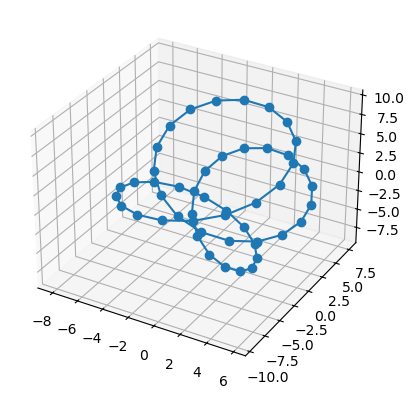

In [20]:
# plot the control points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*control_points.T, 'o-')

Structure is requested to be circular:
 Excess twist per base to make ends meet: 0.79 degrees
Number of base pairs is 349 that fit along the spline.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


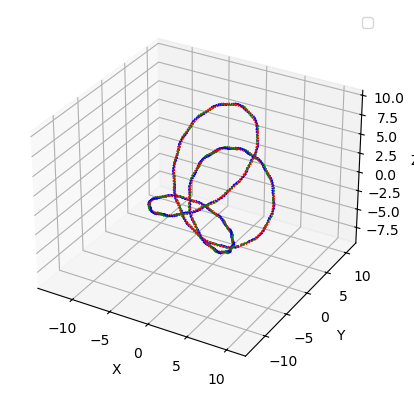

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>)

In [21]:
# Again don't forget the closed statement in the SplineFrames for circular knots
spline = mdna.SplineFrames(control_points, closed=True)
n_bp = spline.frames.shape[0]
print(f'Number of base pairs is {n_bp} that fit along the spline.')
spline.plot_frames(equal=True)

Again to ensure our DNA structure is closed we set circular=True

In [22]:
dna = mdna.StructureGenerator(spline,sequence=sequence,circular=True)
traj = dna.traj
traj

TGAGTCTTGTCGGAAACGGTTATAACCCGCACATAAACAGGGAGTCTGTTCGCCGCTTGCTAAGCTCATCACATTGTGCACAACCAGCGGACATCTTCCCTCCAGGCGAGAATCGGTTATGCGGTTACTAGACGTTTGCAGGAATTGGAATAGAGCTCAACGCCCGTCGATGAAGCGGCGGGACATCCTTGGTGGGCGGAACCTTGATAGCCAATGGCAGAGGGTACCGGGCCCCAGCGGCATATAACGACTCGCCTCAAAGATTCACTCGACACGAGGCTCAGCATCAATCACTACTCAAGCCACCATATAGATTTAAGGAAGACCGGTTAGTGCTGGGTAATTGGTT


/Users/thor/surfdrive/Projects/pymdna/pymdna/utils.py:84: RuntimeWarning: invalid value encountered in divide
  omega_normalized = np.where(omega_norm != 0, omega / omega_norm, omega)


<mdtraj.Trajectory with 1 frames, 14309 atoms, 698 residues, without unitcells at 0x18636a950>

In [23]:
view = nv.show_mdtraj(traj)
#view.add_licorice()
#view.add_spacefill()
view

NGLWidget()

Alternatively, you can define the knot using control points you set yourself. At least 4 control points are required to construct a spline, you can add as many as you want. Control points need to be defined in as cartesian coordinates stored in a numpy array: 

`control_points = np.array([[0,0,0],[10,20,10],[20,30,20],[30,20,30]])`. This will generate a curved sequence of DNA. 

In [232]:
control_points = np.array([[0,0,0],[10,20,10],[20,10,20],[30,20,30]])
spline = mdna.SplineFrames(control_points)

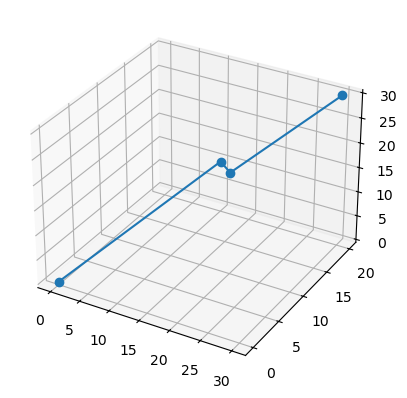

In [233]:
# plot the control points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*control_points.T, 'o-')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of base pairs is 199 that fit along the spline.


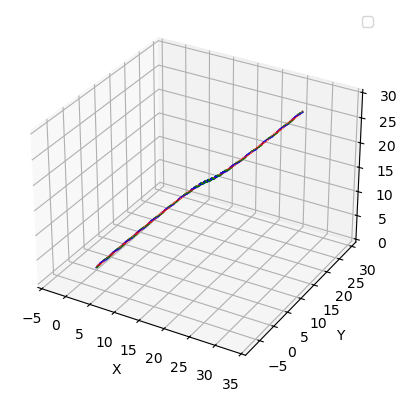

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>)

In [234]:
spline = mdna.SplineFrames(control_points)
n_bp = spline.frames.shape[0]
print(f'Number of base pairs is {n_bp} that fit along the spline.')
spline.plot_frames(equal=True)

In [235]:
dna = mdna.StructureGenerator(spline,sequence=sequence)
traj = dna.traj
traj

GCGGGAAGATAATGGGACCGTGTAGACCGACTATGGACACCCTTGTTGGACTTGAAGCAATCGCACGAAATTTTTTCCAGCTTCGCTGCCGTTCGGCAACACCCTGGTACAGTGAGGCCAATCGCTTAATCACTGGCCAGGTTGCGAGGGTTGCACTGACCAACTTCAGCATTGTTAAGTATTTCGGTGCTACGAGTAG


<mdtraj.Trajectory with 1 frames, 8159 atoms, 398 residues, without unitcells at 0x46e050750>

In [236]:
view = nv.show_mdtraj(traj)
#view.add_licorice()
#view.add_spacefill()
view

NGLWidget()